<a href="https://colab.research.google.com/github/Aranguri/causal-map/blob/master/Exploring_word_representations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments
Embed size = 1. Middle word randomly changed.

I designed the task initially to assign a random word to the middle word of a sentence. However, if that new word is totally random, it would easy for the nn to get an acceptable accuracy, because it just needs to see whether the word in the middle is common or not. (That turns out to be a good proxy for the sentence was changed or not, achieving an accuracy of 85%) {image in desktop}

Embed size = 1. Middle word randomly changed (placing more probability mass on the words that appear the most)

Best dev acc shofar: .78
Best tr acc shofar: .83

# Specific things
## Experiments
* what happens when we slowly decrease the size of the embeddings? say we have embeddings of size 15 and embeddings of size 16 for the same data. Or what happens if we decrease the size from vocab_size to 32. (we coudl start with random weights or we could also start with the one-hot encoding)
* Are the different entries for a representation vector correlated?
* does the nn arrive to the same embeddings in different training times? 
* try with an embedding of one.
* Does it make sense to use several layers to compute the embeddings?
* We can visulize each dimension separately, and we can compute the correlation between the dimensions.
* explore representations in different layers (are they more abstract the more deeper they are)
* what's the difference between cosine similarity and norm? are there other ways to measure distances between vectors?
* Run controlled experiment with N interations and different values for each hyperparam to understand what makes a good net. (hyperparams = {lr, reg, gradient clipping})
* Are there dimensions more important than others? We can test this by removing some dimensions.
* Try forcing the representation to have a unit vector

## Task
* try changing more than only one word and try also changing other word than the middle one.
* add predict the next word task

## Others
* make gpu/tpu work
* improve last nn.

# Log
The iterative process is

1) improve the representation embeddings

2) experiment with the representation embeddings.

We would also like to improve the nn that takes those embeddings and solves the task. And we could also add another task in the future. 

In [0]:
embed_size = 32
batch_size = 256
vocab_size = 10000
h1_size = 64
h2_size = 32
#h3_size = 64
seq_length = 5

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import itertools
from IPython.display import clear_output
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import files

word_to_i = keras.datasets.imdb.get_word_index()
word_to_i = {k:(v+3) for k,v in word_to_i.items()}
word_to_i["<PAD>"] = 0
word_to_i["<START>"] = 1
word_to_i["<UNK>"] = 2
word_to_i["<UNUSED>"] = 3

i_to_word = dict([(value, key) for (key, value) in word_to_i.items()])

def decode_review(text):
  return ' '.join([i_to_word.get(i, '?') for i in text])

In [0]:
(prev_x_train, _), (prev_x_test, _) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

In [186]:
x_train, y_train, new_x_train, j = [], [], {}, 0

for x in prev_x_train:
  for i in range(0, len(x) - seq_length, seq_length):
    new_x_train[j] = x[i:i + seq_length]
    j += 1
new_x_train = np.array([v for v in new_x_train.values()])

flat_x = new_x_train.flatten()
counter = Counter(flat_x.tolist())
weights = [counter[i] / len(flat_x) for i in range(10000)]
random_words = np.random.choice(np.arange(10000), len(new_x_train), p=weights)
  
for i, x in enumerate(new_x_train):
  #print(i)
  change = np.random.randint(2)
  sentence = x
  sentence[(seq_length - 1) // 2] = random_words[i] if change else sentence[(seq_length - 1) // 2]
  x_train.append(sentence)
  y_train.append(change)

y_train = np.array(y_train).reshape(-1, 1)
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]
  
def ps(a0, a1=None):
  print(np.shape(a0))
  if type(a1) != type(None): print(np.shape(a1)) 


KeyboardInterrupt: ignored

In [0]:
def local_plot(d1, d2):
  v1, v2 = list(d1.values()), list(d2.values())
  plt.plot(v1, label='train')
  plt.plot(v2, label='dev')
  plt.legend()
  plt.show()
  clear_output(wait=True)

Step 119700. Tr loss: 0.3475029468536377 Tr acc: 0.83203125 Dev acc: 0.76953125


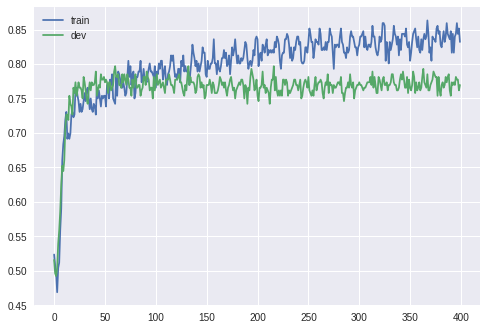

In [41]:
reg = 3e-3
embeddings_global = None

with tf.device('/gpu:0'):
  tf.reset_default_graph()
  x = tf.placeholder(tf.int32, [batch_size, seq_length])
  y = tf.placeholder(tf.float32, [batch_size, 1])
  embeddings = tf.Variable(tf.random_normal((vocab_size, embed_size), stddev=.1))

  w1 = tf.Variable(tf.random_normal((seq_length * embed_size, h1_size), stddev=.1))
  b1 = tf.Variable(tf.zeros((h1_size)))
  w2 = tf.Variable(tf.random_normal((h1_size, h2_size), stddev=.1))
  b2 = tf.Variable(tf.zeros((h2_size)))
  w3 = tf.Variable(tf.random_normal((h2_size, 1)))
  b3 = tf.Variable(tf.zeros((1)))

  a0 = tf.nn.embedding_lookup(embeddings, x)
  a0_reduced = tf.reshape(a0, shape=(batch_size, seq_length * embed_size))

  a1 = tf.nn.relu(tf.matmul(a0_reduced, w1) + b1)
  a2 = tf.nn.relu(tf.matmul(a1, w2) + b2)
  a3 = tf.nn.sigmoid(tf.matmul(a2, w3) + b3)
  a3_clipped = tf.clip_by_value(a3, .001, .999)

  loss = tf.reduce_mean(y * -tf.log(a3_clipped) + (1 - y) * -tf.log(1 - a3_clipped))
  loss += reg * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3))
  optimizer = tf.train.AdamOptimizer(learning_rate=3e-4)
  minimize = optimizer.minimize(loss)

  tr_loss, tr_acc, dev_loss, dev_acc, n = {}, {}, {}, {}, 0
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(120000):
      x_tr_batch = x_train[n:n+batch_size]
      y_tr_batch = y_train[n:n+batch_size]    
      n = (n + batch_size) % 800000
      
      tr_loss[i], _  = sess.run([loss, minimize], feed_dict={x: x_tr_batch, y: y_tr_batch})
      #print(tr_losses)
      #plot(tr_loss)
      #print ('Tr loss: ', tr_loss[i])

      if i % 300 == 0:
        [pred] = sess.run([a3], feed_dict={x: x_train[128:384], y: y_train[128:384]})
        tr_acc[i] = np.mean((np.array(pred) > 0.5) == y_train[128:384])
  
        [pred] = sess.run([a3], feed_dict={x: x_val[:256], y: y_val[:256]})
        dev_acc[i] = np.mean((np.array(pred) > 0.5) == y_val[:256])
        print(f'Step {i}. Tr loss: {tr_loss[i]} Tr acc: {tr_acc[i]} Dev acc: {dev_acc[i]}')
        
        local_plot(tr_acc, dev_acc)
        
        [embeddings_global] = sess.run([embeddings])

In [0]:
def dist(u, v):
  #return np.square(u - v).sum()
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))#np.square(u - v).sum()


## Note 1
After training the word embeddings, I'm visualizing each dimension independently. 

In [0]:
embeds = embeddings_global[0].T
np.savez('embeds.txt', embeds)
files.download('embeds.txt.npz')

In [80]:
from scipy import stats
import time
ps(embeds)
for embed in embeds:
  print(f'Mean: {embed.mean()}. Var: {embed.var()}. Skew {stats.skew(embed)}')

  '''
print(np.array(vs).var())
print(np.random.randn(100).var())
#print(stats.normaltest(np.random.normal(0, 1, ))
#ps(vs)
plt.scatter(np.arange(start, end), vs)
plt.plot()
plt.show()
plt.scatter(np.arange(start, end), np.random.randn(end-start) * .1)
plt.plot()
plt.savefig("abc.png")
#files.download("embed.txt") 
'''

(10000, 32)
Mean: -0.030542446300387383. Var: 0.04425908625125885. Skew 0.2846430838108063
Mean: -0.042752332985401154. Var: 0.04455975443124771. Skew 0.014005600474774837
Mean: -0.033891461789608. Var: 0.03971902281045914. Skew 0.09530991315841675
Mean: -0.009355323389172554. Var: 0.04556833952665329. Skew -0.22286581993103027
Mean: -0.05469589680433273. Var: 0.047887302935123444. Skew 0.04966903477907181
Mean: 0.03604558855295181. Var: 0.0435684435069561. Skew -0.14031240344047546
Mean: 0.010180145502090454. Var: 0.0527084656059742. Skew -0.2656247019767761
Mean: 0.032700106501579285. Var: 0.04028382524847984. Skew -0.1961362212896347
Mean: 0.03741251677274704. Var: 0.044769756495952606. Skew -0.13445697724819183
Mean: 0.0402456559240818. Var: 0.043540362268686295. Skew 0.07432618737220764
Mean: 0.015515350736677647. Var: 0.045221298933029175. Skew 0.007062905002385378
Mean: 0.008234107866883278. Var: 0.05274730175733566. Skew 0.0017690042732283473
Mean: 0.027126846835017204. Var: 0.

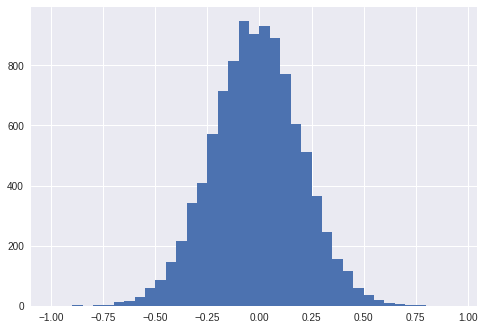

KeyboardInterrupt: ignored

In [86]:
for embed in embeds:
  plt.hist(embed, bins=np.arange(-1, 1, .05))
  plt.show()
  time.sleep(.3)
  clear_output(wait=True)

Now let's look at the outliers. In the following plot we have one point with value -1.7.

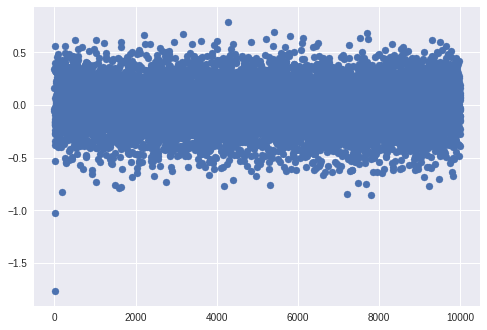

In [95]:
i = 3
plt.scatter(np.arange(len(embeds[i])), embeds[i])

 Let's see what word it is and what values it has in other coordinates

In [131]:
print(embeds[3][10])
print(embeds[:,10].var())
#plt.scatter(np.arange(len(embeds[i][10:11])), embeds[i][10:11])

-1.7653743
0.55565184


That's the point we were looking for. Note that the variance is pretty high. In fact, it's one of the points with the largest variance, as we could see in the next section. 

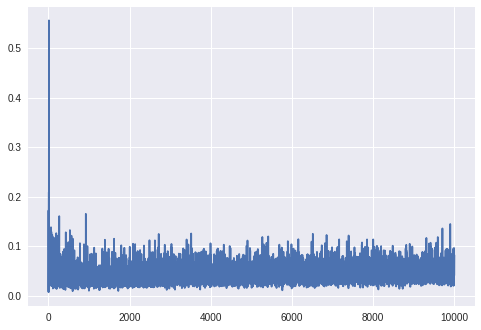

In [140]:
variances = [embed.var() for embed in embeds.T[0:10000]]
plt.plot(np.arange(len(variances)), variances)

Note that the vectors with largest variance are in the first 1000. This means that the vectors that appear the most are the one with highest variance. (This could be because the neural network is forced to learn better representations (more exact) of the words that appear the most, so as to learn when it's correct to use them.)

In [139]:
sel_v = embeds[:, 10]
nearest_ixs = np.argsort([dist(sel_v, v) for v in embeds.T])
print(i_to_word[nearest_ixs[-1]])

br


It wasn't even a word. It was the ```<br>``` special character for new lines. :). Now, let's see what other words (or whatever) have most variance.

In [153]:
np.argsort(variances)[-100:]

array([5366, 8031, 9417,  161, 8964, 5905,  219,  958, 9410, 8196, 4465,
        432, 8093, 4881,  774, 8481, 2353,  520, 1793, 6733,  181,   25,
       8815, 2865, 7719, 4319, 5688, 3446, 5301,  474, 5986,  874,    6,
       2135,  473, 3030, 8900,   72, 2083, 9373, 3992,  775, 6812,   13,
       9900,  586, 5372, 9413, 9555,   80, 7725,  490, 6482,  192, 7350,
       5897, 4903, 2621, 2488, 1390, 3403, 8001, 7849, 7162, 6156, 1616,
        598,   14,  222,  144, 9311,  215, 9592, 5269,  100, 5414,  203,
        566,  238, 7395, 6852,   92,    4, 2716, 6513, 3516,  191,  426,
         70,  528, 9706,   62,  924, 9899,  265,  920,    1,    7,    8,
         10])

Okay, let's see the variances of the twenty words with most variance.

In [234]:
for i, sel_i in enumerate(np.argsort(variances)[-1000:]):
  sel_v = embeds[:, sel_i]
  nearest_ixs = np.argsort([dist(sel_v, v) for v in embeds.T])
  print(i, i_to_word[nearest_ixs[-1]])

0 chemical
1 deepest
2 temporary
3 dozen
4 irwin
5 preferred
6 islands
7 erika
8 sidewalk
9 verbal
10 load
11 tremendous
12 weekly
13 pole
14 gena
15 string
16 discovers
17 thru
18 august
19 constructed
20 educational
21 checked
22 director's
23 societal
24 bend
25 bonanza
26 whipped
27 applied
28 thurman
29 feels
30 goods
31 interaction
32 melinda
33 selection
34 clash
35 relief
36 attracted
37 deals
38 david's
39 trusted
40 bury
41 importantly
42 conditions
43 complains
44 clutter
45 goes
46 plague
47 connect
48 showdown
49 spotted
50 spinal
51 previews
52 introduction
53 expect
54 ended
55 immortal
56 masturbation
57 bishop
58 watched
59 hybrid
60 crooked
61 began
62 mentioning
63 find
64 biblical
65 unfolds
66 parking
67 hum
68 monstrosity
69 operatic
70 suffice
71 emphasize
72 sensibility
73 management
74 writer's
75 reminiscent
76 lds
77 rub
78 bus
79 murderers
80 warn
81 marital
82 does
83 delicate
84 chance
85 stardust
86 michael's
87 garland
88 actual
89 depend
90 swear
91 see

KeyboardInterrupt: ignored

It's interesting that can't, couldn't, can, and won't are consecutive in variance. It could be because they representation is similar. Let's test that hyphothesis.

can't
couldn't
can
won't


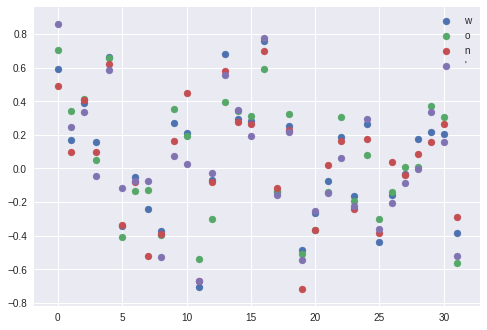

In [180]:
for sel_i in np.argsort(variances)[-14:-10]:
  sel_v = embeds[:, sel_i]
  plt.scatter(np.arange(len(sel_v)), sel_v)
  nearest_ixs = np.argsort([dist(sel_v, v) for v in embeds.T])
  print(i_to_word[nearest_ixs[-1]])
  plt.legend(i_to_word[nearest_ixs[-1]])

Notice above that the points go together almost always. In fact, in some dimensions they are almost in the same value (eg the dimesnion 17.) It would be nice to see what's the dimension of the "negation," because in that dimension we should have the points for can't, couldn't, and won't in one cluster and can in other cluster. But maybe the representation of the negativity is distributed. This could be the case: if we observe dimensions 7, 10, 19, 20, and 26, we can see the red dot (which represents can) far away from the dots that have the negated pattern. There is no dimension where the blue dot is far away from the others. It makes sense because we have the point for "can" (it shares everything with "can't" except the negation,) and we have the point "couldn't" (it shares everythign with "can't" except the term.)

We can make a control test to understand this better. First, let's see whether this happens with all points with high variance or it's something particular of the words {can, can't, couldn't, won't}. We can see that the plot below depicting the words {can't, couldn't, recalls, fi} has much more variance.

can't
couldn't
recalls
fi


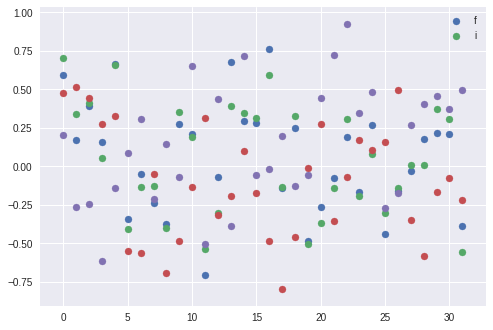

In [186]:
for sel_i in np.argsort(variances)[[-14, -13, -10, -8]]:
  sel_v = embeds[:, sel_i]
  plt.scatter(np.arange(len(sel_v)), sel_v)
  nearest_ixs = np.argsort([dist(sel_v, v) for v in embeds.T])
  print(i_to_word[nearest_ixs[-1]])
  plt.legend(i_to_word[nearest_ixs[-1]])

Let's see if there is a dimension that detects the tense of a word. We are going to select three common words in present tense and three common words in past tense.

realised
grew
wanted
listened
apologize
delve
participate
tend


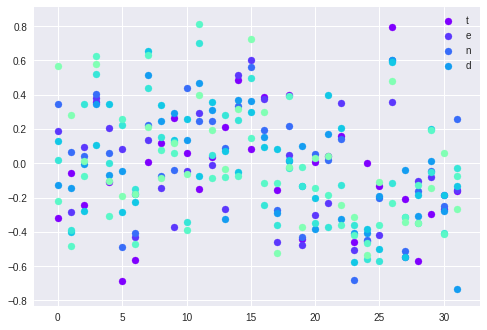

In [216]:
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, .5, 8))

for sel_i, color in zip(np.argsort(variances)[[-54, -62, -66, -99, -98, -52, -50, -84]], colors):
  sel_v = embeds[:, sel_i]
  plt.scatter(np.arange(len(sel_v)), sel_v, color=color)
  nearest_ixs = np.argsort([dist(sel_v, v) for v in embeds.T])
  print(i_to_word[nearest_ixs[-1]])
  plt.legend(i_to_word[nearest_ixs[-1]])

Dimension 3 and 19 seem to be doing what we are looking for. If that's the case, dimensions 3 and 19 should be somewhat correlated. We can test our hyphothesis.

In [207]:
np.correlate(embeds[3, :], embeds[19, :])

array([-101.786156], dtype=float32)

Our hyphothesis didn't work. Say we want to measure the correlation between two random variables. One way to do this is to cluster the data for each of the two random variables. Then, we select the mapping from one cluster of one variable to the other that maximizes the misclassified variables (ie we will send variables from one cluster to other.) The correlation is how good is this mapping. A correlation of 1 would mean that we have say four clusters on each variable and the correspondence is optimal. This could be useful to measure the correlation in the plot above. 

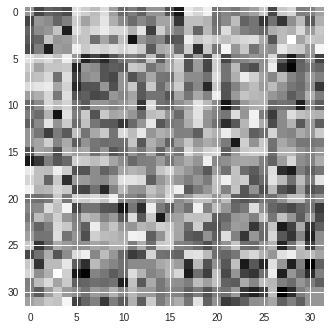

In [233]:
correlation = [[int(np.correlate(embeds[i, :], embeds[j, :])[0]) if i != j else 0 for i in range(32) ] for j in range(32)]
plt.imshow(correlation)

We are treating our dataset as a random variable with 32 dimensions. We have 10000 observations of that random variable. 

Let's look at synonyms and their value in the different dimensions. 

In [247]:
sel_v = embeds[:, 184]
nearest_ixs = np.argsort([dist(sel_v, v) for v in embeds.T])
print(i_to_word[184])
for i in list(reversed(nearest_ixs))[:10]:
  print(i, i_to_word[i])

pretty
184 pretty
55 very
966 incredibly
2087 overly
2612 downright
340 completely
179 quite
1238 surprisingly
1624 professional
1018 fairly


Let's select "pretty" and "very."  

very
pretty
0.18764403
0.1879734


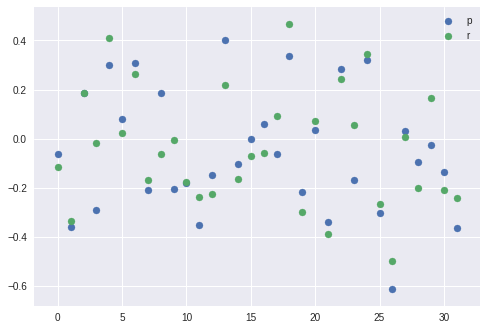

In [255]:
for embed in embeds.T[[55, 184]]:
  plt.scatter(np.arange(len(embed)), embed)
  nearest_ixs = np.argsort([dist(embed, v) for v in embeds.T])
  print(i_to_word[nearest_ixs[-1]])
  plt.legend(i_to_word[nearest_ixs[-1]])
print(embeds[2,55])
print(embeds[2,184])

Notice that in dimension 2, they have a very similar value. It's worth noting that it's not necessary to use all the dimensions in the representation. It makes sense for the neural network to use only so many dimensions for a given word. 

Let's see if there is some sort of detector of numerical values. 

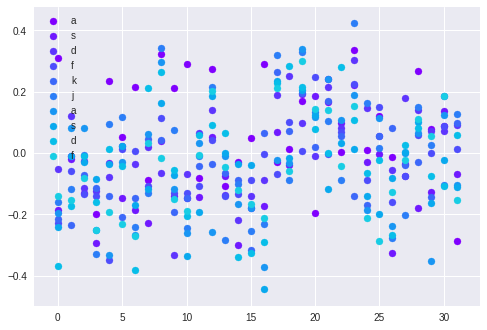

In [272]:
colors = cm.rainbow(np.linspace(0, .3, 10))
for num, color in zip(np.arange(10), colors):
  ix = word_to_i[str(num)]
  embed = embeds[:, ix]
  plt.scatter(np.arange(len(embed)), embed, color=color)
  plt.legend('asdfkjasdf')
  #nearest_ixs = np.argsort([dist(embed, v) for v in embeds.T])
  #print(i_to_word[nearest_ixs[-1]])
  #plt.legend(i_to_word[nearest_ixs[-1]])
#print(embeds[2,55])
#print(embeds[2,184])

Dimension 16 seems to have something. 

In [193]:
#sel_v = embed[word_to_i['mr']]# - embed[word_to_i['woman']] +  embed[word_to_i['actress']]
#for i in reversed(nearest_is):
#  print(i_to_word[i])
a = [46, 48, 50, 34 ,38, 23, 25]
[-(100 - b) for b in a]
  


[-54, -52, -50, -66, -62, -77, -75]

# Exp2:
What's the space of valid word embeddings? Say I train several times a neural net to solve a given task. Are the generated word embeddings correlated in some way? 

In [0]:
# Utilities
def ps(a1, a2=None, a3=None, a4=None, a5=None):
    for a in [a1, a2, a3, a4, a5]:
        if a is not None:
            print (np.shape(a))
            
word_to_v = lambda word, embeds: embeds[word_to_i[word]]
nearest_ixs = lambda sel_v, embeds: np.argsort([dist(sel_v, v) for v in embeds])

def dim_plot(v1, v2, w1, w2):
  plt.scatter(np.arange(len(v1)), v1, label=w1)
  plt.scatter(np.arange(len(v2)), v2, label=w2)
  plt.legend()

In [0]:
embeds1 = np.load('embeds.txt.npz')['arr_0'].T
embeds2 = embeddings_global

In [64]:
v1 = word_to_v('he', embeds2)
for i in reversed(nearest_ixs(v1, embeds2)): print (i_to_word[i])

he
she
they
i
we
who
nobody
everybody
it
someone
everyone
there
you
alex
they'll
ing
somebody
todd
whoever
sophie
karen
neither
'i
stella
george
rukh
gregory
rodriguez
josh
reportedly
this
doyle
rko
they've
paul
andy
cinderella
alexandre
lung
quaid
beth
carey
tracy
i'll
charlie
barely
ripping
debbie
dave
madonna
you'd
jesus
christopher
sondra
jennifer
molly
ollie
these
which
clark
hoffman
spock
eugene
gandhi
you've
sam
everything
guns
tokyo
that
lugosi
streisand
norwegian
you'll
henry
dennis
hawke
donna
terry
let's
chang
warden
shepard
pumbaa
what
boll
repeatedly
deathtrap
she'll
i'd
ins
ben's
anyone
harrison
caine
washington
they'd
eventually
felix
midler
clint
aniston
fawcett
sarah
amitabh
gunga
pia
bert
culkin
adequately
mary
tony
kazan
principles
both
here
soon
caroline
developments
i've
he'll
undertaker
bruce
angie
bach
canada
why
william
jagger
abruptly
sincerely
sid
muted
bathing
faye
franco
nor
liam
jules
kubrick
already
parrot
sho
chan
itself
alice
tho
sirk
jameson
marcel
stan

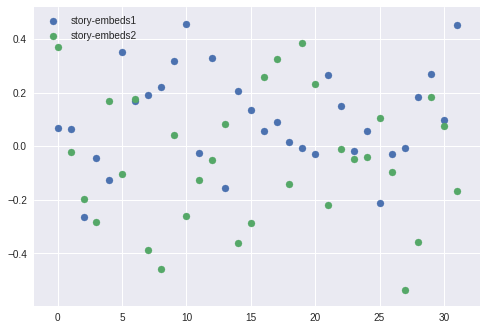

In [65]:
v1 = word_to_v('story', embeds1)
v2 = word_to_v('story', embeds2)
dim_plot(v1, v2, 'story-embeds1', 'story-embeds2')

The problem with the visualization above is that the neural net doesn't care whether it puts some information in dimension 3 or 17. The number of the dimension doesn't have meaning for the neural net.

But if both embeddings are related, they should be a matrix A such that $v_1^TAv_2 >> 0$ with $v_1 \in embeds_1$ and $v_2 \in embeds_2.$ The matrix A represents the change in coordinates of the word embeddings, so that $Av_2$ is in the same basis as $v_1.$ Now, we have two vectors in the same space that we can compare, so we perform the dot product $v_1^TAv_2.$ We know that a dot product of zero means that the vectors are orthogonal, while a dot product of 1 means they are the same vector (in the case of dealing with unit vectors.)

Now, for every pair of vectors, if they span the whole space (ie, if they don't have zeros in any coordinate,) then there exists a matrix that makes them equal. But it doesn't make sense to have a different matrix for every pair of vectors. We want only one matrix. That matrix will represent the change of basis from the space $embeds_2$ to $embeds_1.$ 

So we want to find the matrix that makes the product of the two vectors the largest.

In [143]:
embeds1 = np.array([v / np.linalg.norm(v) for v in embeds1])
embeds2 = np.array([v / np.linalg.norm(v) for v in embeds2])

train_x, test_x = embeds1[:8000], embeds1[8000:]
train_y, test_y = embeds2[:8000], embeds2[8000:]

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, use_bias=False)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(train_x, train_y, epochs=5)
model.evaluate(test_x, test_y)
(w) = model.layers[0].get_weights()

Epoch 1/5
8000/8000 [==============================] - 1s 133us/step - loss: 0.0344 - acc: 0.1190
Epoch 2/5
8000/8000 [==============================] - 1s 94us/step - loss: 0.0165 - acc: 0.2775
Epoch 3/5
8000/8000 [==============================] - 1s 101us/step - loss: 0.0128 - acc: 0.3485
Epoch 4/5
8000/8000 [==============================] - 1s 104us/step - loss: 0.0118 - acc: 0.3695
Epoch 5/5
2000/2000 [==============================] - 0s 123us/step


Distance: 0.7128554


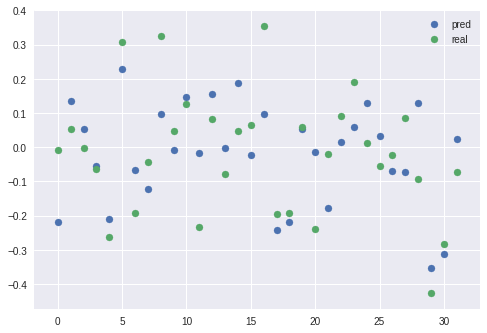

In [144]:
pred = test_x[0].dot(w[0])
real = test_y[0]
dim_plot(pred, real, 'pred', 'real')
print('Distance:', dist(pred, real))

The plot above shows us that there seems to be a relationship between the predicted vectors (where we used the learned matrix A) and the real vectors. But if we look at the plot below, we still can see that relationship. For instance, the first three dimensions seem to be correlated. It's only when we see at the dot product between the two vectors that we can discern between something being related or not.

Distance: -0.2888283


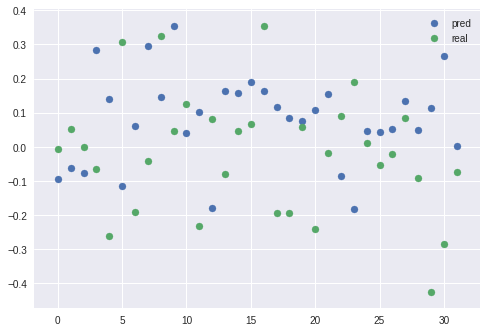

In [145]:
pred = test_x[1].dot(w[0])
real = test_y[0]
dim_plot(pred, real, 'pred', 'real')
print('Distance:', dist(pred, real))

AttributeError: ignored

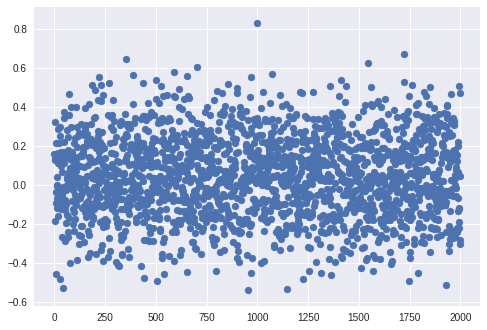

In [148]:
pred = test_x[1000].dot(w[0])
plt.scatter(np.arange(2000), [dist(pred, v) for v in test_y])

What does that mean? The matrix that we learned succesfully converts vectors from one space to another! As we have unit vectors, the best case would be to have 1 in the y-axis. That would mean that the matrix A perfectly converts from one space to the other. 

We can look at the training examples, to see whether there is overfitting to the training data or there is underfitting in our model.

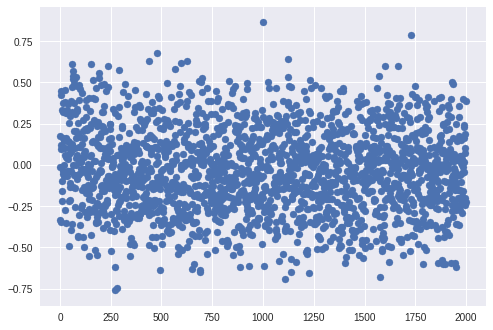

In [156]:
pred = train_x[1001].dot(w[0]) 
plt.scatter(np.arange(2000), [dist(pred, v) for v in train_y[:2000]])

It doesn't seem that we have overfitting: the accuracy in the training data is similar to that of the test data. We could try to add a bias term to the neural net and to train for more epochs. But before that, we need to know how good a tranformation is. 

In [0]:
def measure_transf(transf, xs, ys):
  # After transforming x and getting t, if the vector y corresponding to 
  #  y is the nearest, we count one point. Otherwise, zero points.
  return np.mean([np.argmax([dist(transf(x), y) for y in ys]) == i for i, x in enumerate(xs)])
  

In [181]:
# Round 1: no bias, 20 epochs
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, use_bias=False)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=200, verbose=0)
(w) = model.layers[0].get_weights()
transf = lambda x: x.dot(w)
measure_transf(transf, test_x[:800], test_y[:800])

0.84625

In [172]:
# Round 2: no bias, 5 epochs
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, use_bias=False)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=5, verbose=0)
(w) = model.layers[0].get_weights()
measure_transf(transf, test_x[:800], test_y[:800])

0.84125

In [171]:
# Round 3: bias, 20 epochs
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=20, verbose=0)
(w, b) = model.layers[0].get_weights()
transf = lambda x: x.dot(w) + b
measure_transf(transf, test_x[:800], test_y[:800])

0.8425

In [176]:
# Round 4: radical change: one more layer
model = tf.keras.models.Sequential([
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(100, activation=tf.nn.relu),
  tf.keras.layers.Dense(100, activation=tf.nn.relu),
  tf.keras.layers.Dense(32)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=20, verbose=1)

Epoch 1/20
8000/8000 [==============================] - 2s 262us/step - loss: 0.0177 - acc: 0.2533
Epoch 2/20
8000/8000 [==============================] - 1s 162us/step - loss: 0.0126 - acc: 0.3531
Epoch 3/20
8000/8000 [==============================] - 1s 164us/step - loss: 0.0121 - acc: 0.3669
Epoch 4/20
8000/8000 [==============================] - 1s 162us/step - loss: 0.0119 - acc: 0.3671
Epoch 5/20
8000/8000 [==============================] - 1s 163us/step - loss: 0.0118 - acc: 0.3651
Epoch 6/20
8000/8000 [==============================] - 1s 163us/step - loss: 0.0117 - acc: 0.3734
Epoch 7/20
8000/8000 [==============================] - 1s 161us/step - loss: 0.0117 - acc: 0.3759
Epoch 8/20
8000/8000 [==============================] - 1s 161us/step - loss: 0.0116 - acc: 0.3771
Epoch 9/20
8000/8000 [==============================] - 1s 165us/step - loss: 0.0116 - acc: 0.3765
Epoch 10/20
8000/8000 [==============================] - 1s 161us/step - loss: 0.0115 - acc: 0.3794
Epoch 11/

ValueError: ignored

In [180]:
(w1, b1) = model.layers[1].get_weights()
(w2, b2) = model.layers[2].get_weights()
(w3, b3) = model.layers[3].get_weights()
transf = lambda x: np.maximum(np.maximum(x.dot(w1) + b1, 0).dot(w2) + b2, 0).dot(w3) + b3
measure_transf(transf, test_x[:800], test_y[:800])

0.82125